In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy import stats

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

In [15]:
# Сохранение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [16]:
%%time

# обучение модели baseline prophet
bl_prophet = Prophet()
bl_prophet.fit(df_train)

02:10:47 - cmdstanpy - INFO - Chain [1] start processing
02:10:47 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 281 ms
Wall time: 1.02 s


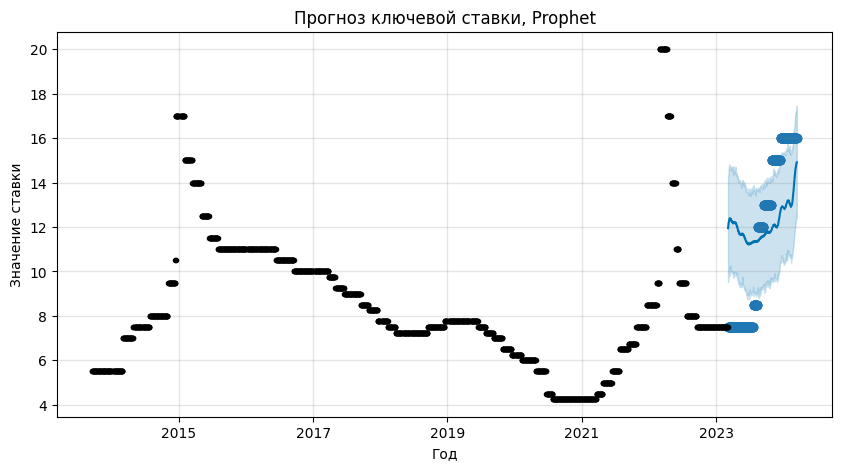

In [17]:
# смотрим совпадение фактического курса с предсказанным курсом baseline prophet
fig, ax = plt.subplots(figsize= (10, 5))

predict = bl_prophet.predict(df_test)
fig = bl_prophet.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'])
ax.set_title('Прогноз ключевой ставки, Prophet')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

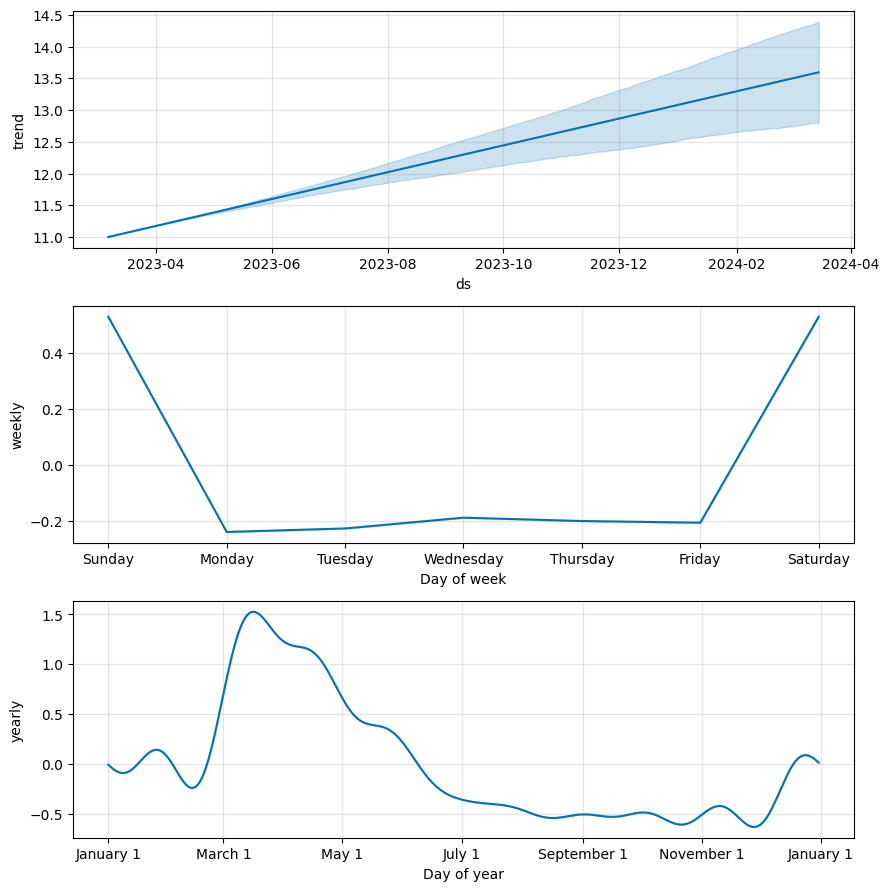

In [18]:
# смотрим тренд, годовые и сезонные признаки
fig = bl_prophet.plot_components(predict)
plt.show()

In [19]:
# выводиим метрики mae и mape для оценкии baseline prophet 
metrics = get_metrics(y_test=df_test['y'], y_pred=predict['yhat'], name='Baseline Prophet')
metrics

,model,MAE,MAPE_%
0,Baseline Prophet,2.931437,0.307276
